# **Experiment 2: Feature Engineering**

## ***Objectives for this Notebook***
* Showcase feature engineering, dimensionality reduction techniques, Pipeline, and different ways to evaluate your models.

Machine learning models thrive on good data. But raw data often comes messy and unrefined, holding hidden gems amidst irrelevant clutter. This is where feature engineering comes in to offer valuable insights and enhance our datasets for better model performance.

**Feature Engineering** is the process of transforming raw data into features that are suitable for training and deploying machine learning models. Simply, it's about:
* Selecting the right features: Choosing the most relevant features that hold predictive power for your target variable. Think carefully, irrelevant features can mislead your model!
* Transforming features: Scaling, normalizing, or encoding categorical data to ensure all features play fair in the model's eyes. No one wants features dominating the competition due to unfair advantages!
* **Creating new features: Combining existing features or extracting hidden patterns to unlock deeper insights. New features can be like secret weapons for your model!**

For this project, we are going to focus on creating new features using algorithms that are also used for another technique called dimensionality reduction.

**Dimensionality reduction** is a technique used in machine learning to reduce the number of features in a dataset while preserving its essential information. The goal is to simplify the data and improve computational efficiency, mitigate the curse of dimensionality, and enhance the performance of machine learning models. Because we're not really working with a large dataset, we don't need to implement dimensionality reduction in this notebook. But it's important to know that our game plan for creating new features is to use dimensionality reduction techniques such as NMF, LDA, and PCA, to extract latent features, and then appending those latent features to our current feature space. The process of capturing of new features is also called **feature extraction**.

**Algorithms**:
* *Non-Negative Matrix Factorization (NMF)*: NMF is a factorization technique that decomposes a matrix into two non-negative matrices. It is particularly useful for non-negative data, such as images or text, and is often applied in topic modeling and image processing.
* *Latent Dirichlet Allocation (LDA)*: LDA is a probabilistic generative model used for topic modeling. It assumes that documents are mixtures of topics and that each word's presence is attributable to one of the document's topics. LDA helps discover the underlying topics in a collection of documents.
* *Principal Component Analysis (PCA)* finds the simplest "directions" in your data that capture the most variation, letting you see the big picture with fewer dimensions.


## **1.) Loading the dataset and setting parameters**

In [48]:
import pandas as pd
import numpy as np
import os

# Dimensionality reduction algorithms
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA # algorithms to extract latent features

# Training
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import random
from sklearn.utils import check_random_state

seed_value = 42

# Set Python seed
random.seed(seed_value)

# Set NumPy seed
np.random.seed(seed_value)

# Set scikit-learn seed
sklearn_random_state = check_random_state(seed_value)

In [10]:
microbiome_df = pd.read_csv("./dataset/microbiome_preprocessed_files/microbiome_merged_dfs.csv")

In [11]:
print(microbiome_df.shape)
microbiome_df.head()

(512, 133)


,SampleID,Simonsiella,Treponema,Campylobacter,Helicobacter,Paracoccus,Comamonas,Pseudomonas,Xanthomonas,Agrobacterium,...,Hungatella,Pseudopropionibacterium,Peptoanaerobacter,Emergencia,Prevotellamassilia,Criibacterium,Fournierella,Negativibacillus,Duodenibacillus,label
0,TCGA-CG-5720-01A,0.0,0.0,0.000000,0.895050,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,STAD
1,TCGA-CN-4741-01A,0.0,0.0,0.010470,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HNSC
2,TCGA-BR-6801-01A,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,STAD
3,TCGA-IG-A3I8-01A,0.0,0.0,0.000000,0.067717,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ESCA
4,TCGA-L5-A4OT-01A,0.0,0.0,0.012202,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ESCA


In [12]:
classes = ["HNSC", "STAD", "COAD", "ESCA", "READ"]

## **2.) Feature Engineering with Cross Validation, Pipeline, and Hyperparameter Grid Search**

Remember we talked about feature engineering is about creating new features? Before we can proceed with the classification, we need to create those new latent features.

**Latent features** are hidden, underlying characteristics of your data revealed through dimensionality reduction techniques like NMF, LDA, and PCA. They capture significant relationships between your original features but aren't directly observable, acting as compressed representations of the data's essence.

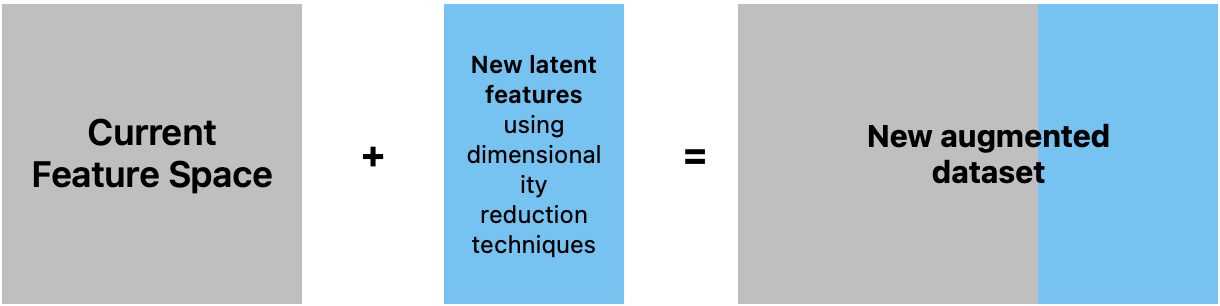

This means we need to update our data slicer so that it incorporates a way to extract these new latent features using dimensionality reduction techniques (NMF, LDA, PCA), and appends these new latent features to our current feature space.

When we implement NMF, LDA, and PCA, we will use GridSearchCV to help us determine the best hyperparameters. All of these algorithms accept an `n_component` argument, which means "Number of components to keep." Think of it as how many data points you want these algorithms to extract for you when you run them through the dataset.

Here's the game plan of how we're going to update the data slicer.

[a. Extending the hyperparameter grid](#a-extending-the-hyperparameter-grid)  
[b. Extract new features using GridSearchCV and Pipeline](#b-extracting-latent-features-using-gridsearchcv-and-pipeline)

### **a. Extending the hyperparameter grid**

First, we will need the best hyperparameters from the first experiment. We will use the best hyperparameters for the Random Forest classifier so we don't need to repeat those steps.

In [14]:
# Get the best hyperparameters from notebook 2 or experiment 1
exp1_best_hyperparam_report = pd.read_csv("./dataset/microbiome_preprocessed_files/exp1_best_hyperparam.csv")
exp1_best_hyperparam_report

,label,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,test_score,mean_train_score,mean_validation_score
0,HNSC,gini,21,61,1,42,51,0.792271,0.940221,0.845135
1,STAD,gini,11,101,1,2,101,0.772232,0.974606,0.833919
2,COAD,gini,11,61,1,42,101,0.921960,0.952209,0.924366
3,ESCA,entropy,11,81,1,22,1,0.526144,0.787640,0.716555
4,READ,gini,11,61,1,2,1,0.500000,0.827371,0.677520


Let's set up our hyperparameter grids. Remember we have different best hyperparameters among the  different cancer types.  
* For examples, HNSC's best hyperparameter for criterion is gini, while ESCA is entropy.  

The code below is to create different hyperparameter grids that incorporates the best hyperparameters from experiment 1 + the new hyperparameter grids for the NMF, LDA, and PCA algorithms.

In [15]:
# Hyperparameters for the dimensionality reduction techniques. These value ranges is what the paper used for tuning their hyperparameters.
nmf_pca_param_grid = {
    "transformer__n_components": list(range(4,65)) # In paper, features 4 to 64
}

lda_param_grid = {
    "transformer__n_components": list(range(1, len(classes))) # In paper, features 1 to length of class-1
}

In [18]:
def create_hyperparameter_grids(report_df, additional_param=None):
    """
    Creates the extended hyperparameter grids: best Random Forest hyperparameters + new hyperparameters grids for dimensionality reduction algorithms
     
    input:
    report_df (Dataframe): The report from experiment one/ output of the best_hyperparameter_to_df()
    additional_param (dict): Defaults to none, any additional hyperparameters to add to the hyperparameter grid.

    output:
    new_hyperparameter_grid_by_class (dict): contains the new extended hyperparameter grids
    """
    
    new_hyperparameter_grid_by_class = {}

    # Read the best hyperparameters from experiment 1
    exclude_cols = ["label", "test_score", "mean_train_score", "mean_validation_score"] # We don't want these columns to be in our future grid parameters
    if report_df is None or report_df.empty:
        raise ValueError("Report DataFrame is required.")
    
    # For each cancer type
    for c in report_df.index: 
        # Choose a row (class) from the report DataFrame
        selected_class = report_df.index[c]
        # Get the best hyperparameters and remove excluded columns
        exp1_best_hyperparameters = report_df.loc[selected_class].drop(exclude_cols).to_dict()

        exp1_best_hyperparameters = {f"{key}": [value] for key, value in exp1_best_hyperparameters.items()} # The format we want for classifier hyperparameters

        if additional_param != None:
            # Add the additional parameters
            exp1_best_hyperparameters = {f"rf__{key}": value for key, value in exp1_best_hyperparameters.items()} #Adjust prefix of hyperparameters
            combined_param_grid = {**exp1_best_hyperparameters, **additional_param}
            new_hyperparameter_grid_by_class[report_df.loc[selected_class]["label"]] = combined_param_grid
        else:
            new_hyperparameter_grid_by_class[report_df.loc[selected_class]["label"]] = exp1_best_hyperparameters

    return new_hyperparameter_grid_by_class

Let's see this function in action.

In [17]:
combined_param_grid = create_hyperparameter_grids(report_df=exp1_best_hyperparam_report, additional_param=lda_param_grid)
combined_param_grid

{'HNSC': {'rf__criterion': ['gini'],
  'rf__max_depth': [21],
  'rf__max_features': [61],
  'rf__min_samples_leaf': [1],
  'rf__min_samples_split': [42],
  'rf__n_estimators': [51],
  'transformer__n_components': [1, 2, 3, 4]},
 'STAD': {'rf__criterion': ['gini'],
  'rf__max_depth': [11],
  'rf__max_features': [101],
  'rf__min_samples_leaf': [1],
  'rf__min_samples_split': [2],
  'rf__n_estimators': [101],
  'transformer__n_components': [1, 2, 3, 4]},
 'COAD': {'rf__criterion': ['gini'],
  'rf__max_depth': [11],
  'rf__max_features': [61],
  'rf__min_samples_leaf': [1],
  'rf__min_samples_split': [42],
  'rf__n_estimators': [101],
  'transformer__n_components': [1, 2, 3, 4]},
 'ESCA': {'rf__criterion': ['entropy'],
  'rf__max_depth': [11],
  'rf__max_features': [81],
  'rf__min_samples_leaf': [1],
  'rf__min_samples_split': [22],
  'rf__n_estimators': [1],
  'transformer__n_components': [1, 2, 3, 4]},
 'READ': {'rf__criterion': ['gini'],
  'rf__max_depth': [11],
  'rf__max_features': 

You'll notice these prefixes "rf__" and "transformer__" before the hyperparameter names. The prefixes added to hyperparameter
names in GridSearchCV are used to distinguish between different hyperparameters. The prefix is simply the name of the estimator
that the hyperparameter is being tuned for. For example, if we are tuning the hyperparameters for Random Forest, then the prefix for those hyperparameters will be "rf__", and if we are tuning the hyperparameters for dimensionality reduction techniques (data transformers) then the predix will be "transformers__". These prefixes are abritrary, you can name it however you like using Pipeline.

**Pipeline**: This module chains the data transformation and the classificiation tasks together into a single, powerful workflow. Its uses are the following:
* **Chaining transformations and estimators**: You define a list of steps, each consisting of a transformer (e.g., scaling, encoding) and its corresponding parameters. The transformers pre-process the data, while the final estimator (e.g., classifier, regressor) learns from the transformed data.
* **Streamlined workflow**: Instead of calling individual fit and predict methods on each step separately, you simply call them on the Pipeline object, simplifying your code and reducing boilerplate.
* **Joint parameter tunin**g: You can optimize hyperparameters for all components in the pipeline simultaneously through grid search or other methods, ensuring all steps work together seamlessly.

You will see Pipieline in action in the following function.

### **b. Extracting latent features using GridSearchCV and Pipeline**


In [30]:
def augment_dataset(X,y,report_df,algorithm="NMF"):
    """
    This function is what will append the new latent features to our current dataset. 

    input:
    X (Dataframe): features
    y (Dataframe): targets
    hyperparameter (Dataframe): hyperparameter report from experiment 1
    algorithm (str): name of algorithm you want to use

    output:
    augmented_datasets_dict (dict): holds the new augmented datasets
    """

    augmented_datasets_dict = {}
    
    # Create the pipeline object. Here we are chaining the dimensionality reduction step and the classifier step.

    algorithms_dict = {"NMF": NMF(), "LDA": LatentDirichletAllocation(), "PCA": PCA()}

    pipeline = Pipeline([
        ('transformer', algorithms_dict[algorithm]),
        ('rf', RandomForestClassifier(random_state=seed_value))
    ])

    # Create the hyperparameter grids
    combined_param_grid = create_hyperparameter_grids(report_df, 
                                                      lda_param_grid if algorithm=="LDA" else nmf_pca_param_grid)
 
 
    print(f'Using algorithm {algorithm}:')

    for c in classes:
        print(f"Class {c}")
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value)

        # Create the GridSearchCV object
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=combined_param_grid[c], # pass the combined_param_grid
            cv=cv,
            n_jobs=-1,  # Use all available processors
        )

        # Perform the grid search
        print("Fitting..")
        grid_search.fit(X, y)

        # Print the best hyperparameters
        print("Best Hyperparameters:", grid_search.best_params_)

        # Get the best model
        best_model = grid_search.best_estimator_

        # note: LENGTH OF DATASET SHOULD STAY SIMILAR TO ORIGINAL, but length of features should increase by the best n_components

        # Transform the original dataset to get the latent features
        latent_features = best_model.named_steps['transformer'].transform(X)
        print(f"Count of new columns/latent features: {len(latent_features.T)}")

        print(f"Count of columns of original feature set: {len(X.T)}")

        # Concatenate the original dataframe with the new features
        feature_augmented = pd.concat((X, pd.DataFrame(latent_features, index=X.index, columns=[f"new_feature {str(x)}" for x in range(1,len(latent_features.T)+1)])), axis=1)
        print(f"Count of columns of augmented feature set: {len(feature_augmented.T)}")
        print(f"Count of rows of augmented dataset: {len(feature_augmented)}")

        augmented_datasets_dict[c] = feature_augmented

    return augmented_datasets_dict




Let's see this function in action.

In [31]:
exclude_cols = ["SampleID", "label"] # Exclude these columns in the current dataset because they're neither of our features

features = microbiome_df.drop(columns=exclude_cols)
target = microbiome_df["label"]

In [32]:
# Run augment_dataset() for LDA
augmented_features_dict = augment_dataset(features, 
                                          target, 
                                          exp1_best_hyperparam_report, 
                                          algorithm="LDA")

Using algorithm LDA:
Class HNSC
Fitting..
Best Hyperparameters: {'rf__criterion': 'gini', 'rf__max_depth': 21, 'rf__max_features': 61, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 42, 'rf__n_estimators': 51, 'transformer__n_components': 4}
Count of new columns/latent features: 4
Count of columns of original feature set: 131
Count of columns of augmented feature set: 135
Count of rows of augmented dataset: 512
Class STAD
Fitting..
Best Hyperparameters: {'rf__criterion': 'gini', 'rf__max_depth': 11, 'rf__max_features': 101, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 101, 'transformer__n_components': 4}
Count of new columns/latent features: 4
Count of columns of original feature set: 131
Count of columns of augmented feature set: 135
Count of rows of augmented dataset: 512
Class COAD
Fitting..
Best Hyperparameters: {'rf__criterion': 'gini', 'rf__max_depth': 11, 'rf__max_features': 61, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 42, 'rf__n_est

To inspect the new augmented dataframe for each class you can run `augmented_features_dict["class"]`

In [33]:
augmented_features_dict["HNSC"] # scroll to the last columns to see the new features!

,Simonsiella,Treponema,Campylobacter,Helicobacter,Paracoccus,Comamonas,Pseudomonas,Xanthomonas,Agrobacterium,Bradyrhizobium,...,Emergencia,Prevotellamassilia,Criibacterium,Fournierella,Negativibacillus,Duodenibacillus,new_feature 1,new_feature 2,new_feature 3,new_feature 4
0,0.0,0.000000,0.000000,0.895050,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.578585,0.129331,0.166121,0.125963
1,0.0,0.000000,0.010470,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.127067,0.484797,0.260092,0.128044
2,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.128322,0.386377,0.356119,0.129182
3,0.0,0.000000,0.000000,0.067717,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.162307,0.136129,0.573201,0.128363
4,0.0,0.000000,0.012202,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.127821,0.607420,0.136039,0.128720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.0,0.000000,0.000000,0.106557,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.182512,0.132203,0.557213,0.128072
508,0.0,0.175564,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.129332,0.605803,0.135460,0.129405
509,0.0,0.335060,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.128388,0.599305,0.143995,0.128312
510,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.014781,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.133432,0.126088,0.614311,0.126169


## **3.) Creating a data slicer**

Now we have our new augmented datasets, we can finally update our data slicer! This data slicer is similar to experiment 1, the only addition is that it runs the feature engineering functions we have in the [2nd section](#2-feature-engineering-with-cross-validation-pipeline-and-hyperparameter-grid-search).

In [42]:
def exp2_data_slicer(dataframe, 
                         label_column, 
                         classes, 
                         report_df, 
                         algorithm="NMF", 
                         train_test=True):
    """
    Creates experiment 2 datasets by augmented the original dataset with new latent features using the given algorithm.

    inputs:
    dataframe (Dataframe): the original dataset to be appended
    label_column (str): str the column name representing the labels.
    report_df (Dataframe): the best hyperparameters for Random Forest from experiment 1
    algorithm (str): Defaults to "NMF", the dimensionality reduction algorithm desired
    train_test (bool) Splits the features and target into train test, if false then it won't perform a train test split.

    output:
    dataset_dict (dict): a dictionary where the keys is the targeted class and the values are its corresponding features and labels
    """
    augmented_dataset_dict = {}

    exclude_cols = ["SampleID", "label"] # we don't need these columns to be passed to our augment_dataset()
    feat = dataframe.drop(columns=exclude_cols)
    tar = dataframe["label"]

    # Get latent features and the augmented dataset
    augmented_features_dict = augment_dataset(feat, tar,report_df, algorithm=algorithm)

    # Created
    for c in classes:
        positive_class = c 

        # Create the new dataframe for the One vs All setup
        dframe = pd.DataFrame(index=augmented_features_dict[c].index)
        dframe["SampleID"] = dataframe["SampleID"]
        dframe = pd.concat([dframe, augmented_features_dict[c]], axis=1)
        dframe['label'] = [1 if x == positive_class else 0 for x in dataframe[label_column]]

        # Check
        print(dframe.label.value_counts())

        # Declare what's a feature X or target y
        X = dframe.drop(["SampleID", "label"], axis=1) # Exclude these columns because they're not features 
        y = dframe["label"] 

        # Perform train test 
        if train_test:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=seed_value)
            augmented_dataset_dict[positive_class] = {"train": (X_train, y_train),
                                            "test": (X_test, y_test)}
            
        # Else, just return features and targets sets as is
        else:
            augmented_dataset_dict[positive_class] = {"feature": X, 
                                            "label": y}

    return augmented_dataset_dict

Because we have 3 algorithms, we will need to create 3 different data loaders corresponding to each algorithm, i.e. `exp2_datasets_nmf` corresponds to NMF, and so on and so forth.

In [40]:
exp2_datasets_nmf = exp2_data_slicer(dataframe=microbiome_df, 
                                      label_column="label", 
                                      classes=classes, 
                                      report_df=exp1_best_hyperparam_report,
                                      algorithm="NMF", 
                                      train_test=True)

Using algorithm NMF:
Class HNSC
Fitting..
Best Hyperparameters: {'rf__criterion': 'gini', 'rf__max_depth': 21, 'rf__max_features': 61, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 42, 'rf__n_estimators': 51, 'transformer__n_components': 42}
Count of new columns/latent features: 42
Count of columns of original feature set: 131
Count of columns of augmented feature set: 173
Count of rows of augmented dataset: 512
Class STAD
Fitting..
Best Hyperparameters: {'rf__criterion': 'gini', 'rf__max_depth': 11, 'rf__max_features': 101, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 101, 'transformer__n_components': 29}
Count of new columns/latent features: 29
Count of columns of original feature set: 131
Count of columns of augmented feature set: 160
Count of rows of augmented dataset: 512
Class COAD
Fitting..
Best Hyperparameters: {'rf__criterion': 'gini', 'rf__max_depth': 11, 'rf__max_features': 61, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 42, 'rf__n

In [43]:
exp2_datasets_lda = exp2_data_slicer(dataframe=microbiome_df, 
                                      label_column="label", 
                                      classes=classes, 
                                      report_df=exp1_best_hyperparam_report, 
                                      algorithm="LDA", 
                                      train_test=True)

Using algorithm LDA:
Class HNSC
Fitting..
Best Hyperparameters: {'rf__criterion': 'gini', 'rf__max_depth': 21, 'rf__max_features': 61, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 42, 'rf__n_estimators': 51, 'transformer__n_components': 4}
Count of new columns/latent features: 4
Count of columns of original feature set: 131
Count of columns of augmented feature set: 135
Count of rows of augmented dataset: 512
Class STAD
Fitting..
Best Hyperparameters: {'rf__criterion': 'gini', 'rf__max_depth': 11, 'rf__max_features': 101, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 101, 'transformer__n_components': 4}
Count of new columns/latent features: 4
Count of columns of original feature set: 131
Count of columns of augmented feature set: 135
Count of rows of augmented dataset: 512
Class COAD
Fitting..
Best Hyperparameters: {'rf__criterion': 'gini', 'rf__max_depth': 11, 'rf__max_features': 61, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 42, 'rf__n_est

## Task 1:

Use the `exp2_data_slicer()` to create the experiment 2 datasets using PCA. Name it `exp2_datasets_pca`.

In [ ]:
# Write your code here

In [77]:
exp2_datasets_pca = exp2_data_slicer(microbiome_df, "label", classes=classes, report_df=exp1_best_hyperparam_report, algorithm="PCA", train_test=True)

Using algorithm PCA:
Class HNSC
Fitting..
Best Hyperparameters: {'rf__criterion': 'gini', 'rf__max_depth': 21, 'rf__max_features': 61, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 42, 'rf__n_estimators': 51, 'transformer__n_components': 51}
Count of new columns/latent features: 51
Count of columns of original feature set: 131
Count of columns of augmented feature set: 182
Count of rows of augmented dataset: 512
Class STAD
Fitting..
Best Hyperparameters: {'rf__criterion': 'gini', 'rf__max_depth': 11, 'rf__max_features': 101, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 101, 'transformer__n_components': 48}
Count of new columns/latent features: 48
Count of columns of original feature set: 131
Count of columns of augmented feature set: 179
Count of rows of augmented dataset: 512
Class COAD
Fitting..
Best Hyperparameters: {'rf__criterion': 'gini', 'rf__max_depth': 11, 'rf__max_features': 61, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 42, 'rf__n

Let's check one of the training sets, specifically for NMF and HNSC class.

In [44]:
exp2_datasets_nmf["HNSC"]["train"][0]

,Simonsiella,Treponema,Campylobacter,Helicobacter,Paracoccus,Comamonas,Pseudomonas,Xanthomonas,Agrobacterium,Bradyrhizobium,...,new_feature 33,new_feature 34,new_feature 35,new_feature 36,new_feature 37,new_feature 38,new_feature 39,new_feature 40,new_feature 41,new_feature 42
155,0.0,0.010944,0.0,0.000000,0.0,0.0,0.017489,0.0,0.0,0.0,...,0.000337,0.000000,0.000000,0.0,0.000000,0.033033,0.055817,0.000000,0.000596,0.001982
414,0.0,0.000000,0.0,0.107591,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
172,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000014,0.000000,0.000000,0.0,0.106725,0.000000,0.000000,0.000000,0.000000,0.000011
367,0.0,0.000000,0.0,0.421787,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.010985,0.000036,0.0,0.000000,0.000000,0.000000,0.000357,0.000888,0.000000
462,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
198,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.021594,0.015830,0.000000,0.0,0.000000,0.061451,0.000000,0.000103,0.000000,0.000000
211,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## **5.) Training with the new features using GridSearchCV**

To recap, here's what we've done so far. We've done feature engineering using GridSearch that gave us new augmented datasets. With these augmented datasets, we can now train them. The code below is the same `perform_gridsearchcv` function we have in experiment 1, except that the hyperparameter grids are now created using the `create_hyperparameter_grids()`.


In [49]:
def perform_gridsearchcv(dataset_dict, classes, seed=seed_value, cv_n_splits=5, n_jobs=12):
    """
    This function will perform GridSearchCV for each class.

    inputs:
    dataset_dict (dict): datasets from data_slicer()
    classes (list): class names
    seed (int): introduce randomness
    cv_n_split (int): determines how many splits to use in cross validation. Default `5`.
    n_jobs (int): determines how many processes to use. Default `-1`, all processors.
    
    output:
    report (dict): holds the best model object, the best hyperparameters, and evaluation scores for each targeted label.
    """
    
    report = {}

    print("Random Seed: ", seed)
    for c in classes:
        print("Class: ", c)
        train_features = dataset_dict[c]["train"][0]
        train_target = dataset_dict[c]["train"][1]
        test_features = dataset_dict[c]["test"][0]
        test_target = dataset_dict[c]["test"][1]

        # Define the classifier
        rf = RandomForestClassifier(random_state=seed)

        # Get the best hyperparameters for Random Forest
        exp1_best_hyperparameter_grids = create_hyperparameter_grids(exp1_best_hyperparam_report, None)

        # Create a cross validation object 
        cv = StratifiedKFold(n_splits=cv_n_splits, shuffle=True, random_state=seed)

        # Create the GridSearchCV object
        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=exp1_best_hyperparameter_grids[c],
            scoring=make_scorer(balanced_accuracy_score), 
            cv=cv,
            n_jobs=n_jobs,  
            return_train_score=True
)

        # Perform the grid search
        grid_search.fit(train_features, train_target)

        # Access cv_results_ attribute to get detailed results
        cv_results = grid_search.cv_results_

        # Print the best hyperparameters
        print("Best Hyperparameters:", grid_search.best_params_)

        # Get the best model
        best_model = grid_search.best_estimator_

        # Evaluate the best model on test set
        predictions = best_model.predict(test_features)
        
        # Get classification report
        class_report = classification_report(test_target, predictions)
        # print(class_report)

        # Get the balanced accuracy
        balanced_accuracy = balanced_accuracy_score(test_target, predictions)
        print("Test Score:", balanced_accuracy)

        # Create a confusion matrix
        cm = confusion_matrix(test_target, predictions)
        # print(f"\nConfusion matrix for {c}\n")
        print(f"True Positives: {cm[1, 1]}, True Negatives: {cm[0, 0]}, False Positives: {cm[0, 1]}, False Negatives: {cm[1, 0]}")

        # Calculate mean train score and mean test score
        mean_train_score = cv_results['mean_train_score'][grid_search.best_index_]
        mean_test_score = cv_results['mean_test_score'][grid_search.best_index_]

        print("Mean Train Score:", mean_train_score)
        print("Mean Validation Score:", mean_test_score)


        report[c] = {
            "model": best_model,
            "best_hyperparameters": grid_search.best_params_,
            "test_score": balanced_accuracy,
            "mean_train_score": mean_train_score,
            "mean_validation_score": mean_test_score,
            "confusion_matrix": cm,
            "classification_report": class_report,
        }
        
    return report


The block below is how we can save the best hyperparameters and metrics.

In [53]:
def best_hyperparameter_to_df(nested_dict, exp_name):
    """
    Saves the best hyperparameters

    nested_dict (dict): the report
    exp_name (str): name of the experiment

    output:
    df (Dataframe): the table of the best hyperparameters and metrics
    """
     
    path = "./dataset/microbiome_preprocessed_files/"
    data = []

    for key, value in nested_dict.items():
        entry = {'label': key}
        entry.update(value['best_hyperparameters'])
        entry['test_score'] = value['test_score']
        entry['mean_train_score'] = value['mean_train_score']
        entry['mean_validation_score'] = value['mean_validation_score']
        data.append(entry)

    df = pd.DataFrame(data)

    df.to_csv(path+f"{exp_name}_best_hyperparam.csv", index=False)
    return df

### **a.) Run with NMF**

In [51]:
# Run gridsearchcv
exp2_nmf_report = perform_gridsearchcv(exp2_datasets_nmf, classes)

Random Seed:  42
Class:  HNSC
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 21, 'max_features': 61, 'min_samples_leaf': 1, 'min_samples_split': 42, 'n_estimators': 51}
Test Score: 0.8140096618357487
True Positives: 17, True Negatives: 48, False Positives: 6, False Negatives: 6
Mean Train Score: 0.9395981771301001
Mean Validation Score: 0.8127555929195273
Class:  STAD
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 11, 'max_features': 101, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 101}
Test Score: 0.7636116152450091
True Positives: 11, True Negatives: 55, False Positives: 3, False Negatives: 8
Mean Train Score: 0.9769179363806468
Mean Validation Score: 0.8246120546120548
Class:  COAD
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 11, 'max_features': 61, 'min_samples_leaf': 1, 'min_samples_split': 42, 'n_estimators': 101}
Test Score: 0.8956442831215972
True Positives: 17, True Negatives: 52, False Positives: 6, False Negatives: 2
Mean Tr

In [58]:
# Save hyperparameters and metrics
exp2_nmf_best_hyperparam_df = best_hyperparameter_to_df(exp2_nmf_report, "exp2_nmf")
exp2_nmf_best_hyperparam_df

,label,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,test_score,mean_train_score,mean_validation_score
0,HNSC,gini,21,61,1,42,51,0.814010,0.939598,0.812756
1,STAD,gini,11,101,1,2,101,0.763612,0.976918,0.824612
2,COAD,gini,11,61,1,42,101,0.895644,0.954161,0.919604
3,ESCA,entropy,11,81,1,22,1,0.644608,0.801394,0.689897
4,READ,gini,11,61,1,2,1,0.485714,0.849036,0.613838


### **b.) Run with LDA**

In [54]:
exp2_lda_report = perform_gridsearchcv(exp2_datasets_lda, classes)
exp2_lda_report

Random Seed:  42
Class:  HNSC
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 21, 'max_features': 61, 'min_samples_leaf': 1, 'min_samples_split': 42, 'n_estimators': 51}
Test Score: 0.8140096618357487
True Positives: 17, True Negatives: 48, False Positives: 6, False Negatives: 6
Mean Train Score: 0.9072602993643588
Mean Validation Score: 0.8065601793470645
Class:  STAD
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 11, 'max_features': 101, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 101}
Test Score: 0.7722323049001816
True Positives: 11, True Negatives: 56, False Positives: 2, False Negatives: 8
Mean Train Score: 0.9884790163058007
Mean Validation Score: 0.8292041292041293
Class:  COAD
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 11, 'max_features': 61, 'min_samples_leaf': 1, 'min_samples_split': 42, 'n_estimators': 101}
Test Score: 0.8956442831215972
True Positives: 17, True Negatives: 52, False Positives: 6, False Negatives: 2
Mean Tr

{'HNSC': {'model': RandomForestClassifier(max_depth=21, max_features=61, min_samples_split=42,
                         n_estimators=51, random_state=42),
  'best_hyperparameters': {'criterion': 'gini',
   'max_depth': 21,
   'max_features': 61,
   'min_samples_leaf': 1,
   'min_samples_split': 42,
   'n_estimators': 51},
  'test_score': 0.8140096618357487,
  'mean_train_score': 0.9072602993643588,
  'mean_validation_score': 0.8065601793470645,
  'confusion_matrix': array([[48,  6],
         [ 6, 17]]),
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.89      0.89      0.89        54\n           1       0.74      0.74      0.74        23\n\n    accuracy                           0.84        77\n   macro avg       0.81      0.81      0.81        77\nweighted avg       0.84      0.84      0.84        77\n'},
 'STAD': {'model': RandomForestClassifier(max_depth=11, max_features=101, n_estimators=101,
                         random_s

In [59]:
exp2_lda_best_hyperparam_df = best_hyperparameter_to_df(exp2_lda_report, "exp2_lda")
exp2_lda_best_hyperparam_df

,label,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,test_score,mean_train_score,mean_validation_score
0,HNSC,gini,21,61,1,42,51,0.814010,0.907260,0.806560
1,STAD,gini,11,101,1,2,101,0.772232,0.988479,0.829204
2,COAD,gini,11,61,1,42,101,0.895644,0.956357,0.895794
3,ESCA,entropy,11,81,1,22,1,0.526144,0.758810,0.622642
4,READ,gini,11,61,1,2,1,0.492857,0.826838,0.580882


### **c.) Run with PCA**

## Task 2:

Run the `perform_gridsearchcv()` with the PCA dataset. Follow the naming convention used above. For example, if `exp2_lda_best_hyperparam_df` is to LDA then `exp2_pca_best_hyperparam_df` is to PCA

In [ ]:
# Write your code here


In [78]:
exp2_pca_report = perform_gridsearchcv(exp2_datasets_pca, classes)
exp2_pca_report

Random Seed:  42
Class:  HNSC
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 21, 'max_features': 61, 'min_samples_leaf': 1, 'min_samples_split': 42, 'n_estimators': 51}
Test Score: 0.8140096618357487
True Positives: 17, True Negatives: 48, False Positives: 6, False Negatives: 6
Mean Train Score: 0.9409856338806215
Mean Validation Score: 0.8185259913128766
Class:  STAD
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 11, 'max_features': 101, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 101}
Test Score: 0.7722323049001816
True Positives: 11, True Negatives: 56, False Positives: 2, False Negatives: 8
Mean Train Score: 0.9953755680299384
Mean Validation Score: 0.8092207792207793
Class:  COAD
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 11, 'max_features': 61, 'min_samples_leaf': 1, 'min_samples_split': 42, 'n_estimators': 101}
Test Score: 0.9219600725952812
True Positives: 18, True Negatives: 52, False Positives: 6, False Negatives: 1
Mean Tr

{'HNSC': {'model': RandomForestClassifier(max_depth=21, max_features=61, min_samples_split=42,
                         n_estimators=51, random_state=42),
  'best_hyperparameters': {'criterion': 'gini',
   'max_depth': 21,
   'max_features': 61,
   'min_samples_leaf': 1,
   'min_samples_split': 42,
   'n_estimators': 51},
  'test_score': 0.8140096618357487,
  'mean_train_score': 0.9409856338806215,
  'mean_validation_score': 0.8185259913128766,
  'confusion_matrix': array([[48,  6],
         [ 6, 17]]),
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.89      0.89      0.89        54\n           1       0.74      0.74      0.74        23\n\n    accuracy                           0.84        77\n   macro avg       0.81      0.81      0.81        77\nweighted avg       0.84      0.84      0.84        77\n'},
 'STAD': {'model': RandomForestClassifier(max_depth=11, max_features=101, n_estimators=101,
                         random_s

In [80]:
exp2_pca_best_hyperparam_df = best_hyperparameter_to_df(exp2_pca_report, "exp2_pca_v1")
exp2_pca_best_hyperparam_df

,label,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,test_score,mean_train_score,mean_validation_score
0,HNSC,gini,21,61,1,42,51,0.814010,0.940986,0.818526
1,STAD,gini,11,101,1,2,101,0.772232,0.995376,0.809221
2,COAD,gini,11,61,1,42,101,0.921960,0.952259,0.910080
3,ESCA,entropy,11,81,1,22,1,0.552288,0.781313,0.607126
4,READ,gini,11,61,1,2,1,0.492857,0.853404,0.602604


## **6.) Results and Discussion**

**Experiment 1 Results**
| Classification | Paper Test Accuracy | Experiment 1 Test Accuracy |
|-----------------|----------------------|-----------------------------|
| HNSC vs All     | 80.78                | 79.29                       |
| STAD vs All     | 82.84                | 77.22                       |
| COAD vs All     | 93.54                | 92.20                       |
| ESCA vs All     | 61.37                | 52.61                       |
| READ vs All     | 56.43                | 50.00                       |

**Experiment 2 Results: NMF**
| Classification | Paper Test Accuracy | Experiment 2 Test Accuracy |
|-----------------|----------------------|-----------------------------|
| HNSC vs All     | 83.16                | 81.40                       |
| STAD vs All     | 83.02                | 76.36                       |
| COAD vs All     | 89.16                | 89.56                       |
| ESCA vs All     | 55.59                | 64.46                       |
| READ vs All     | 55.71                | 48.57                       |

**Experiment 2 Results: LDA**
| Classification | Paper Test Accuracy | Experiment 2 Test Accuracy |
|-----------------|----------------------|-----------------------------|
| HNSC vs All     | 78.50                | 81.40                       |
| STAD vs All     | 86.97                | 77.22                       |
| COAD vs All     | 93.36                | 89.56                       |
| ESCA vs All     | 64.41                | 52.61                       |
| READ vs All     | 60.57                | 49.29                       |



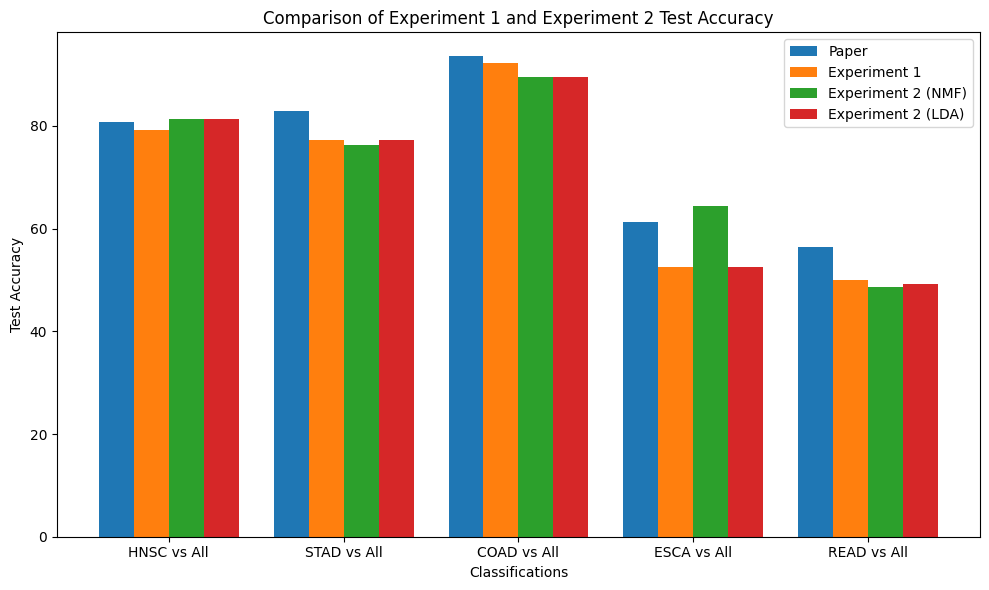

In [72]:
# Get our data for our visualization
classifications = ['HNSC vs All', 'STAD vs All', 'COAD vs All', 'ESCA vs All', 'READ vs All']
paper_accuracy = [80.78, 82.84, 93.54, 61.37, 56.43]
exp1_test_accuracies = [round(val * 100, 2) for val in exp1_best_hyperparam_report["test_score"]] # transform to percentages
exp2_test_accuracies_nmf = [round(val * 100, 2) for val in exp2_nmf_best_hyperparam_df["test_score"]] 
exp2_test_accuracies_lda = [round(val * 100, 2) for val in exp2_lda_best_hyperparam_df["test_score"]] 

# Bar width
bar_width = 0.2
index = np.arange(len(classifications))

# Plotting the bar graphs
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index - bar_width, paper_accuracy, bar_width, label='Paper')
bar2 = ax.bar(index, exp1_test_accuracies, bar_width, label='Experiment 1')
bar3 = ax.bar(index + bar_width, exp2_test_accuracies_nmf, bar_width, label='Experiment 2 (NMF)')
bar4 = ax.bar(index + 2 * bar_width, exp2_test_accuracies_lda, bar_width, label='Experiment 2 (LDA)')

# Adding labels
ax.set_xlabel('Classifications')
ax.set_ylabel('Test Accuracy')
ax.set_title('Comparison of Experiment 1 and Experiment 2 Test Accuracy')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classifications)
ax.legend()

# Display the bar graph
plt.tight_layout()
plt.show()



From the table above, it is clear that the paper results across all classifications outperform both experiment 1 and 2. This difference in performance is expected because we used a distilled version of the hyperparameter grid for experiment 1 to get our best hyperparameters for Random Forest, which we then used for experiment 2. What's interesting here is the comparison between Experiment 1 and Experiment 2.

**Experiment 1 vs Experiment 2**
1. HNSC vs All:
* Both Experiment 2 with NMF and LDA outperformed Experiment 1 and approached the paper accuracy. The additional features seem to have a positive impact.
2. STAD vs All:
* Experiment 2 results are slightly lower than Experiment 1. The additional features might not have significantly improved performance for this classification.
3. COAD vs All:
* Both Experiment 2 results are slightly lower than Experiment 1. The additional features might not have provided a significant advantage for this classification.
4. ESCA vs All:
* Experiment 2 with NMF showed an improvement over Experiment 1, while LDA did not. The impact of additional features varies between methods.
5. READ vs All:
* Experiment 2 results are similar or slightly lower than Experiment 1. The additional features may not have significantly influenced performance for this classification.

In summary, the impact of additional features varies across different classifications. In some cases (e.g., HNSC vs All), the additional features appear to be beneficial, while in others (e.g., STAD vs All), they may not provide a significant improvement. Further analysis, checking variance using multiple seeds, and experimentation are needed to draw more definitive conclusions.

## Task 3

Incorporate the `exp2_test_accuracies_pca` in the graph above. Discuss the performance of PCA. How did it compare with NMF and LDA, and the paper accuracies?

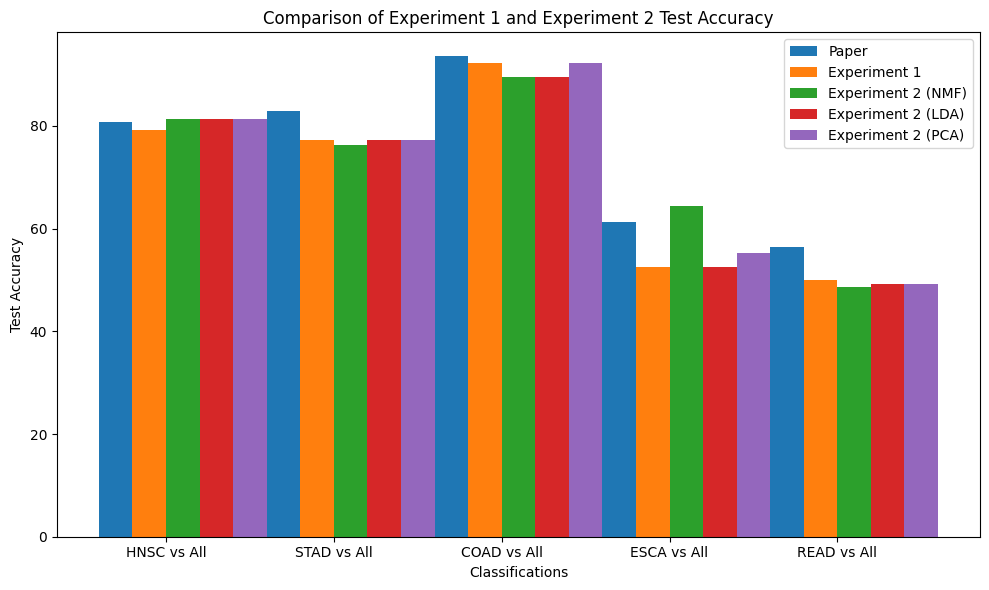

In [85]:
# Write your code here

# Get our data for our visualization
classifications = ['HNSC vs All', 'STAD vs All', 'COAD vs All', 'ESCA vs All', 'READ vs All']
paper_accuracy = [80.78, 82.84, 93.54, 61.37, 56.43]
exp1_test_accuracies = [round(val * 100, 2) for val in exp1_best_hyperparam_report["test_score"]] # transform to percentages
exp2_test_accuracies_nmf = [round(val * 100, 2) for val in exp2_nmf_best_hyperparam_df["test_score"]] 
exp2_test_accuracies_lda = [round(val * 100, 2) for val in exp2_lda_best_hyperparam_df["test_score"]] 
exp2_test_accuracies_pca = [round(val * 100, 2) for val in exp2_pca_best_hyperparam_df["test_score"]] 

# Bar width
bar_width = 0.2
index = np.arange(len(classifications))

# Plotting the bar graphs
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index - bar_width, paper_accuracy, bar_width, label='Paper')
bar2 = ax.bar(index, exp1_test_accuracies, bar_width, label='Experiment 1')
bar3 = ax.bar(index + bar_width, exp2_test_accuracies_nmf, bar_width, label='Experiment 2 (NMF)')
bar4 = ax.bar(index + 2 * bar_width, exp2_test_accuracies_lda, bar_width, label='Experiment 2 (LDA)')
bar5 = ax.bar(index + 3 * bar_width, exp2_test_accuracies_pca, bar_width, label='Experiment 2 (PCA)')

# Adding labels
ax.set_xlabel('Classifications')
ax.set_ylabel('Test Accuracy')
ax.set_title('Comparison of Experiment 1 and Experiment 2 Test Accuracy')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classifications)
ax.legend()

# Display the bar graph
plt.tight_layout()
plt.show()

In [86]:
exp2_test_accuracies_pca

[81.4, 77.22, 92.2, 55.23, 49.29]

1. HNSC vs All:
* NMF, LDA, and PCA show similar test accuracies for this classification. The methods perform comparably in capturing the patterns for HNSC vs All.
2. STAD vs All:
* LDA and PCA outperform NMF in this classification. The additional features in Experiment 2 (LDA) and PCA contribute to better performance compared to NMF.
3. COAD vs All:
* PCA achieves the highest accuracy, followed by NMF and LDA. The additional features in PCA seem to be more beneficial for capturing the patterns in COAD vs All.
4. ESCA vs All:
* NMF performs better than LDA and PCA in this classification. The additional features in LDA and PCA do not seem to contribute positively, and NMF outperforms them.
5. READ vs All:
* NMF, LDA, and PCA show similar test accuracies for this classification. The methods perform comparably in capturing the patterns for READ vs All.

Congratulations! We have accomplished experiment 2. This is the end of the 3-part series that demonstrated the learning outcomes for this class. Take some time to reflect on this accomplishment.